<img src="img/bigsem.png" width="40%" align="right">
<img src="img/logo_wiwi.png" width="20%" align="left">





<br><br><br><br>

## Decision-Focused Analytics
**Winter Term 2021/22**


# 5. Risk Aversion and Chance-Constrained Programming

<img src="img/decision_analytics_logo.png" width="17%" align="right">


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer |  Decision Analytics Group**
                                                    


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numba import vectorize
import pandas as pd
import mip
from mip import maximize
from scipy.optimize import minimize

## Overview

#### Part I:  Risk Orientation / Decision-Making as Shaping Distributions
- Decision Making under Uncertainty as Shaping Distributions
- Comparing Distributions: Stochastic Dominance
- Shaping Distributions by Incorporating Risk Attitude into Decision / Optimization Models

#### Part II: Feasibility Guarantees by Chance-Constrained Programming
- Feasibility Issues in Single-Stage Problems under Uncertainty
- Single Chance Constraints
- Joint Chance Constraints
- Improving Chance-Constrained Programming Formulations


# Part I: Risk Orientation and Decision Making under Uncertainty as Shaping Distributions

## Part I: Risk Orientation and Decision Making under Uncertainty as Shaping Distributions

In the first part, we will introduce the idea that:

**Decision Making under Uncertainty means Shaping Distributions**

In particular, we will answer the following questions:
- when it is appropriate to optimize expected values?
- what is an outcome distribution?
- what kind of useful information does the outcome distribution give us?
- how can we compare outcome distributions?
- how can we modify models to account for risk attitude?

### The Capacity Planning Case Study

- we once again use the capacity planning case study to illustrate aspects of decision making under uncertainty

- it deals with the decision of installing a certain production capacity under **demand uncertainty**
- for a given capacity and for a given demand, we can compute  the profit using the following function
  - recall that we use `vectorize` to allow for a simple and efficient one-line Monte Carlo Simulation


In [2]:
#@vectorize turns a function into a just-in-time compiled vectorized function
@vectorize
def total_profit(capacity,demand):
    return -30*capacity + 40* min(capacity, demand)

- we assume that demand follows a normal distribution and we draw a large sample 

In [3]:
n_samples = 10000
demand_dist = stats.norm(100,25)

# we create a sample vector of demands (demand_dist was defined above)
demands = demand_dist.rvs(n_samples)
demand_sample = np.maximum(demand_dist.rvs(n_samples),0)

## Case Study: Maximizing Expected Total Profit

In the case study, we aimed at finding the decision with an optimal expected profit:
- to be able to use the `minimize` routine for maximization, we define an objective function that gives us the negative expected profit

In [4]:
def neg_expected_profit(capacity, demands):
    return -1*np.mean(total_profit(capacity,demands))

- we can use this function in a call to the `minimize` optimization routine to find the capacity decision that maximizes expected total profit

In [5]:
result = minimize(neg_expected_profit, 100, args=(demands))

print(f'The best decision is: {result.x[0]:.2f}, yielding an expected total profit of {-1 * result.fun:.2f}')

The best decision is: 83.07, yielding an expected total profit of 679.28


## On using the Expected Value as Objective Criterion

So far, we always used the **expected value** for selecting the best decision(s) - when is that appropriate?


**The Expected Profit / Performance is a good choice if**
- the decision problem is solved repeatedly for many times
- the decision maker is risk-neutral
  - e.g. because decision does not have a big impact on the wealth of
    the decision maker

**In the following,**
- we deal with approaches that we can take if this is not the case
- all these approache rely on the idea that the **outcome of a decision under uncertainty is a distribution**

## Outcome Distribution

If the (at least one) **input** of a decision making / optimization problem **is uncertain** then, in general **the output is also uncertain**

Thus, taking a decision under uncertainty leads to an **outcome distribution** $G = f(x,D)$  where
- $f$: objective function
- $x$ decision(s)
- $D$ is the distribution of the outcomes

When approximated with a Monte-Carlo Simulation we have an outcome vector **g** 
- consisting of one objective function value $g_s$ for each sample / scenario $s$

## Visualizing the Outcome Distribution

We can visualize the (sample approximation of the) outcome distribution in two main ways
- using a histogram (approximating the density function)
- the (empirical) cumlative distribution function (also called **risk profile**)
  - for this, we can use the module `ECDF` from statsmodels.



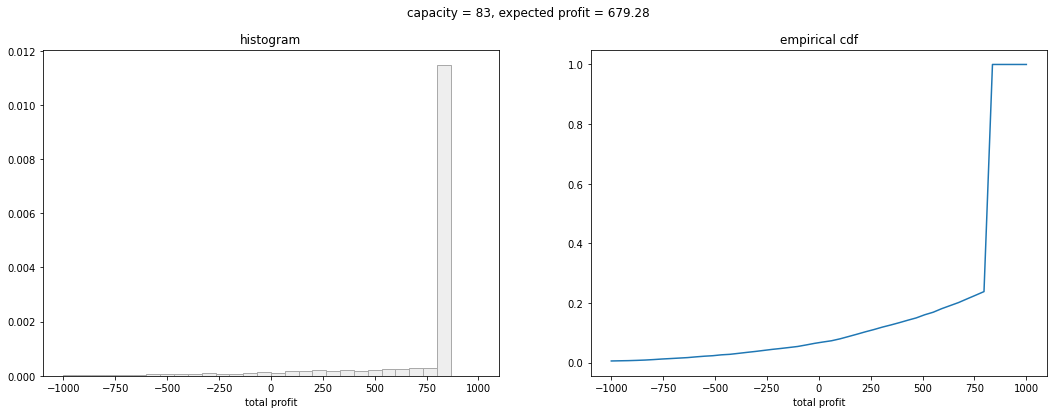

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
capacity = 83
outcomes = total_profit(capacity,demands)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle (f'capacity = {capacity}, expected profit = {np.mean(outcomes):.02f}')
axes[0].hist(outcomes, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
axes[0].set_xlabel('total profit'); 
axes[0].set_title('histogram'); 
xx = np.linspace(-1000,1000)
ecdf = ECDF(outcomes)
axes[1].plot(xx, ecdf(xx),label=f'capacity={capacity}')
axes[1].set_xlabel('total profit'); 
axes[1].set_title('empirical cdf');

## Motivation: Similar Expected Values, Different Distributions


**Let us consider two different capacity installation decisions:**


In [7]:
capacity_a = 63
capacity_b = 100


Let us compare the outcome distributions of the outcomes of the two capacity decisions:


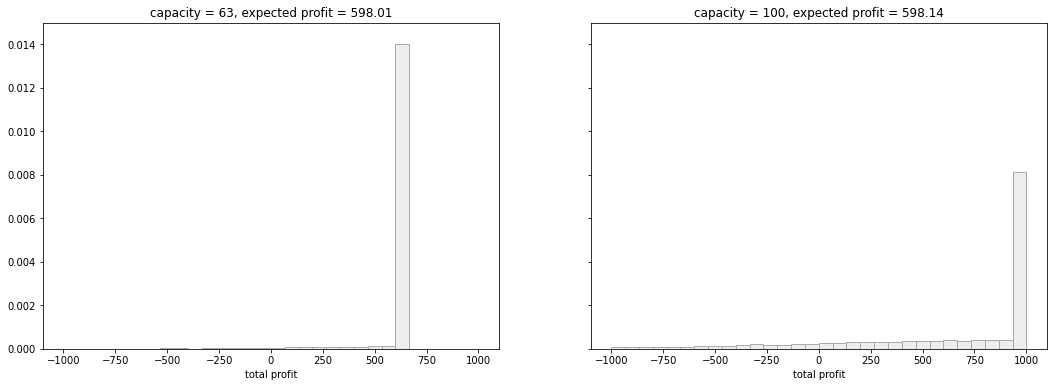

In [8]:
outcomes_a = total_profit(capacity_a,demands)
outcomes_b = total_profit(capacity_b,demands)


fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

   
axes[0].hist(outcomes_a, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
axes[0].set_ylim ([0, 0.015])
axes[0].set_title(f'capacity = {capacity_a}, expected profit = {np.mean(outcomes_a):.02f}')
axes[0].set_xlabel('total profit');   

axes[1].hist(outcomes_b, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
axes[1].set_ylim ([0, 0.015])
axes[1].set_title(f'capacity = {capacity_b}, expected profit = {np.mean(outcomes_b):.02f}')
axes[1].set_xlabel('total profit');   


## Examples for Information to be Obtained from the Outcome Distribution

- the probability of losing money

In [9]:
print(f"For a capacity of {capacity_a}, the probability of losing money is: { np.mean(outcomes_a < 0) :0.2f}" )
print(f"For a capacity of {capacity_b}, the probability of losing money is: { np.mean(outcomes_b <0) :0.2f}" )

For a capacity of 63, the probability of losing money is: 0.02
For a capacity of 100, the probability of losing money is: 0.16


- the probability of reaching / exceeding a target 

In [10]:
target = 500
print(f"For a capacity of {capacity_a}, the probability of exceeding {target} is: { np.mean(outcomes_a >= target ) :0.2f}" )
print(f"For a capacity of {capacity_b}, the probability of exceeding {target}  is: { np.mean(outcomes_b >= target ) :0.2f}" )

For a capacity of 63, the probability of exceeding 500 is: 0.95
For a capacity of 100, the probability of exceeding 500  is: 0.69


- the value below which the worst 5 % outcomes fall (5%-quantile, Value at Risk)

In [11]:
q = 5

def var_5(outcomes): return np.percentile(outcomes,5)

print(f"For a capacity of {capacity_a}, worst {q} % fall below  { var_5(outcomes_a):0.2f}" )
print(f"For a capacity of {capacity_b}, worst {q} % fall below  { var_5(outcomes_b) :0.2f}" )

For a capacity of 63, worst 5 % fall below  445.15
For a capacity of 100, worst 5 % fall below  -664.85


- the average value of the worst 5 % (Conditional Value at Risk, expected shortfall)

In [12]:
def cvar_5(outcomes): return np.mean(outcomes[outcomes < var_5(outcomes)])

print(f"For a capacity of {capacity_a}, the average of the worst {q} % of the outcomes is { cvar_5(outcomes_a) :0.2f}" )
print(f"For a capacity of {capacity_b}, the average of the worst {q} % of the outcomes is { cvar_5(outcomes_b) :0.2f}" )

For a capacity of 63, the average of the worst 5 % of the outcomes is 25.40
For a capacity of 100, the average of the worst 5 % of the outcomes is -1084.60


## Decision Making as Shaping Distributions

Since, as we learned, different decisions lead to different distributions, we can make the following statement:

**Decision Making under Uncertainty means Shaping (Outcome) Distributions**
- this means we decide between outcome distributions
- the objective function can then be seen as a function taking the outcome distribution as input
- we can choose an objective function that reflects our preferences / risk attitude


## The Outcome Distribution in Stochastic Programming

#### Where is the Outcome Distribution in a Stochastic Program?
- discuss how to obtain the outcome distribution
- see how manipulate the outcome distribution to account for risk aversion by:
    - penalizing shortfalls
    - mean-risk optimization with Conditional Value at Risk
- we will use the agricultural case study from video 2 for illustration and exercises


## Review: A Stochastic Programming Formulation for our Case Study

**Sets:**
- $S$  scenario set

**Parameters:**
- $d_s$: demand in units in scenario  $s$
- $p_s$: probability of scenario $s$

**Decision Variables:**
- $x$: capacity installation decision (*first stage* / *here and now* decision) 
- $z_s$: production decision for scenario $s$ (*second stage* / *recourse* decision)


 \begin{align*}
        \max \;        -30x +  & \sum_{s \in S} p_s 40 z_s \\
        \text{s.t.} \qquad   z_s &\leq x \qquad &\forall s \in S \\                  
                         z_s &\leq d_s \qquad &\forall s \in S \\
                         x &\geq 0 \\
 z_s &\geq 0 \qquad &\forall s \in S
\end{align*}

## Review: Implementation in Python


In [13]:

# Create a new model
m = mip.Model("Capacity_Planning_Stochastic")

#sets
n_scenarios = n_samples
scenarios = np.arange(n_scenarios) #in stochastic programming, we call the samples scenarios

#probability of each scenario - in our case, each scenario has prob. 1/|S|
prob = np.full((n_scenarios), 1/n_scenarios)

#parameters
installation_cost = 30
contribution_margin = 40

#decision variables
capacity =  m.add_var(name="capacity", lb=0)

production = [m.add_var(name=f"production{s}", lb= 0) for s in scenarios]

m.objective =  maximize( -installation_cost*capacity + sum(prob[s] * contribution_margin * production[s] for s in scenarios))

for s in scenarios:    
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 

m.optimize()

print(f'Capacity decision: {capacity.x:.02f}')

print(f'Expected Total Profit: {m.objective_value:.02f}' )

Capacity decision: 83.19
Expected Total Profit: 684.97


# The Outcome Distribution in Stochastic Programming

## Model Reformulation for Obtaining the Outcome Distribution

**Remember:** Decision making under uncertainty means shaping distributions
- Where is the outcome distribution in a stochastic program?

**Idea:** Introduce an outcome variable **$g_s$** per scenario (a second-stage variable) and reformulate the model as follows:



\begin{align*}
        \max \;      &\sum_{s \in S} p_s g_s \\
        \text{s.t.} \qquad g_s &=  -30x +  40 z_s  \qquad &\forall s \in S\\
        z_s &\leq x \qquad &\forall s \in S \\                  
                         z_s &\leq d_s \qquad &\forall s \in S \\
                         x &\geq 0 \\
 z_s &\geq 0 \qquad &\forall s \in S
\end{align*}

In a given solution:

- the vector $\mathbf{g}=[g_s]_{s \in S}$ is a sample approximation of the outcome (total profit) distribution given the optimal capacity decision $x$


## Model Reformulation: Implementation in Python

In [14]:
# Create a new model
m = mip.Model("Capacity_Planning_Stochastic")

#decision variables
capacity =  m.add_var(name="capacity", lb=0)

production = [m.add_var(name=f"production{s}",lb=0) for s in scenarios]

## this is the new variable
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)) 

for s in scenarios:   
    m += profit[s] == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 

m.optimize()

print(f'Capacity decision: {capacity.x:.02f}')
print(f'Expected Total Profit: {m.objective_value:.02f}' )




Capacity decision: 83.19
Expected Total Profit: 684.97


## Plotting the Outcome Distribution

As ab example, we can now  use the vector $\mathbf{g}=[g_s]_{s \in S}$ from the optimal solution plot a histogram of the outcompe distribution:

Text(0.5, 0, 'Total Profit')

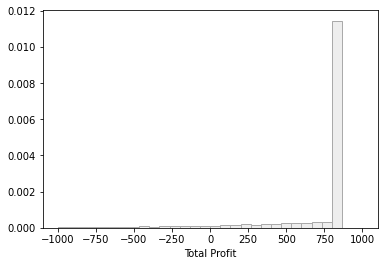

In [15]:
## collect the profit samples into an array
profit_samples = np.array( [ profit[s].x for s in scenarios ])

count, bins, ignored = plt.hist(profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
plt.xlabel('Total Profit')

#plt.savefig('profit_distribution_stochastic_lp.pdf')


## How can we Compare Distributions?

**If decision making means shaping distributions, how can we compare them?**

There is one clear case: **Stochastic Dominance**
- for each outcome, the dominating distribution gives at least as high a probability of obtaining an equal or better outcome than the dominated distribution
- visually, the cdf of the better distribution is always "on the right" of the dominated distribution

**Example:** let us consider a second production technology for our case study that has a **higher investment cost** and a **lower contribution margin** than the original technology, and take the same capacity decision of 80 for both technologies
- then, the outcome distribution of the original techology dominates the second technology


In [ ]:
@vectorize
def total_profit_other_technology(capacity,demands):
    return -31*capacity + 35*min(capacity, demands)

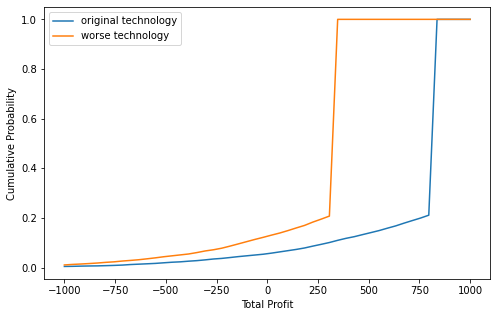

In [16]:
plt.figure(figsize=(8,5))

ecdf = ECDF(total_profit(80,demands))
plt.plot(xx, ecdf(xx), label="original technology")

ecdf = ECDF(total_profit_other_technology(80,demands))
plt.plot(xx, ecdf(xx), label="worse technology")
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Cumulative Probability')

plt.show()
          

## How can we Compare Distributions?

**In general, stochastic dominance is an exception**: Typically, alternatives with a lower risk of bad outcomes also exhibit samller chances of very good outcomes



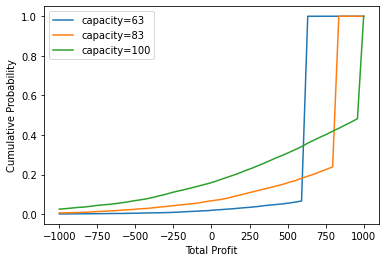

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

values_to_plot = [63, 83, 100]

xx = np.linspace(-1000,1000)

#fig, axes = plt.subplots(1, len(values_to_plot), figsize=(6*len(values_to_plot), 4), constrained_layout=True)

for index in range(len(values_to_plot)):
    ecdf = ECDF(total_profit(values_to_plot[index],demands))
    plt.plot(xx, ecdf(xx),label=f'capacity={values_to_plot[index]}')
    #axes[index].set_title(f'capacity = {values_to_plot[index]}, expected profit = {expected_profit(values_to_plot[index]):.02f}')
    
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Cumulative Probability');

#plt.savefig("cumulative_result_distributions.pdf",bbox_inches="tight")


To decide between outcome distributions we can use (for example), see next video:
- distribution statistics (e.g. mean, mode, ...)
- risk measures
- utility functions



# Excercise: A Second Production Technology





## An additional production technology

The company from the capacity planning case study thinks of installing production capacity using an different production technology (B).

Technology B has a lower installation costs (\\$ 20 per unit), but also a lower contribution margin per sold unit (\\$ 28) compared to the original technology A.

Below, please find our implmentation from last week:

In [18]:

@vectorize
def total_profit_b(capacity,demand):
    return -20*capacity + 28* min(capacity, demand)

demands = demand_dist.rvs(n_samples)
# decision
capacity = 84

#we can now call the function with an array parameter returning an array of profits
profit = total_profit_b(capacity,demands)

expected_profit = np.mean(profit)

print(f'The estimated expected profit is: {expected_profit:.2f}')

The estimated expected profit is: 561.80


**Task:**

Compare the outcome distributions from the optimal decisions for both production technologies:
- compute the best outcome distribution for each of the technologies (either using enumeration or scipy optimize)
- which outcome distribution has a higher probability of losing money?
- does one of the distributions stochastically dominate the other?


In [19]:
def neg_expected_profit_b(capacity, demands):
    return -1*np.mean(total_profit_b(capacity,demands))

result_b = minimize(neg_expected_profit_b, 100, args=(demands))

total_profits_a = total_profit(result.x[0],demands)
total_profits_b= total_profit_b(result_b.x[0],demands)



In [20]:
print(f"For alterative A, the probability of losing money is: { np.mean(total_profits_a < 0) :0.2f}" )
print(f"For alterative B, the probability of losing money is: { np.mean(total_profits_b <0) :0.2f}" )

For alterative A, the probability of losing money is: 0.07
For alterative B, the probability of losing money is: 0.06


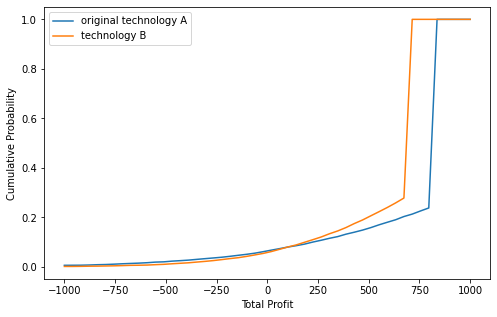

In [21]:
plt.figure(figsize=(8,5))

xx = np.linspace(-1000,1000)

ecdf = ECDF(total_profits_a )
plt.plot(xx, ecdf(xx), label="original technology A")

ecdf = ECDF(total_profits_b )
plt.plot(xx, ecdf(xx), label="technology B")
plt.legend()
plt.xlabel('Total Profit')
plt.ylabel('Cumulative Probability')

plt.show()


Now we consider a combination of both technologies, that is, we might install both technology A and B. 

Since B has a lower profit contribution, you assume that if  both technologies are installed, first A is used to produce up to the installed capacity. If there is demand left, that demand is satisfied by technology B until the installed capacity of B is exhausted.

What is the best combination of technologies A and B in terms of expected total profit? Is B used at all? 

See the solution from the last meeting below:


In [22]:
capacityA = 80
capacityB = 20

@vectorize
def total_profit_both(capacityA, capacityB, demand):
    capacity_cost =  -30*capacityA -20 *capacityB 
    soldA =  min(capacityA, demand)  
    soldB =  min(capacityB, demand-soldA)
    return capacity_cost + 40*soldA + 28*soldB

best_profit = 0
best_A = 0
best_B = 0

for capA in np.arange(160):
    for capB in np.arange(160):
        profit = np.mean(total_profit_both(capA,capB,demands))
        if profit > best_profit:           
            best_profit = profit
            best_A = capA
            best_B = capB
            
print(f'Best A: {best_A}, best b {best_B}, estimated expected profit is: {best_profit:.2f}')

Best A: 76, best b 10, estimated expected profit is: 687.63


**Task:**

Compare the outcome distributions from the optimal decisions for only using the original techology and for the combination of  both production technologies computed using the code above!
- modify the code from the cell above to also store the best profit distribution
- compute the best outcome distribution for each of the technologies (either using enumeration or scipy optimize)
- which outcome distribution has a higher probability of losing money?
- does one of the distributions stochastically dominate the other?


# Shaping Distributions: Risk-Oriented Decision Making under Uncertainty

## This Part: Risk-Oriented Decision Making under Uncertainty

So far, we learned that 

- **decision making under uncertainty means shaping distributions**

Next, we deal with approaches for influencing the shapes of distributions in a way that it reflects **risk preferences**:
- penalizing shortfalls below targets
- utility theory: utility functions as objective functions
- mean-risk objectives based on risk measures

# Shaping Distributions by Penalizing Shortfalls


## Shaping Distributions by Penalizing Shortfalls


**Idea: Set target values and penalize the violations / shortfall**
- as soon the target is violated, the shortfall is penalized with a
  weight $\lambda$
- can be used to reduce risk of obtaining bad or negative outcomes

**Example for our case study:**
- say we'd like to penalize total profits smaller than \\$500k
- we can change our objective function $f$ to $f'$ as follows:

$$f'(x,d) = f(x,d) - \lambda \max(500 - f(x,d), 0)$$

For deciding under demand uncertainty, we then then maximize the **expected value  $E(f'(x,D))$** instead of maximizing $E(f(x,D))$

In Python:


In [23]:
target_profit = 500
shortfall_penalty = 2

@vectorize
def total_profit_and_shortfall_penalty(capacity,demand, target_profit, shortfall_penalty):
    profit = -30*capacity + 40* min(capacity, demand)
    return profit - shortfall_penalty * max(target_profit - profit, 0)

    

## Optimizing the Shortfall-based Penalty

**Let us optimize for the shortfall-based penalty**

Recall that the optimal decision in the risk-neutral case is $\approx$ 83.

Using $f'$ as optimization criterion, a target value of 500  and a penalty of 2, we get the following result:



In [24]:
# not that we negate the function here since we'd like to use minimize

def neg_expected_total_profit_and_shortfall_penalty(capacity, demands, target_profit, shortfall_penalty):
    return -np.mean(total_profit_and_shortfall_penalty(capacity, demands, target_profit, shortfall_penalty))

shortfall_penalty = 2
result = minimize(neg_expected_total_profit_and_shortfall_penalty,100,args=(demands, 500, shortfall_penalty))

print(f'Given a target value of {target_profit} and a shortfall penalty lambda= {shortfall_penalty}, the optimal capacity decision is {result.x[0]:.2f}')

Given a target value of 500 and a shortfall penalty lambda= 2, the optimal capacity decision is 70.95


A penalty of 4 is even more risk averse:

In [25]:
shortfall_penalty = 4
result = minimize(neg_expected_total_profit_and_shortfall_penalty,100,args=(demands, 500, shortfall_penalty))

print(f'Given a target value of {target_profit} and a shortfall penalty lambda= {shortfall_penalty}, the optimal capacity decision is {result.x[0]:.2f}')

Given a target value of 500 and a shortfall penalty lambda= 4, the optimal capacity decision is 64.60


##  Targets and Shortfall Penalties in Stochastic Programming

**Key Idea**:
- set a target, e.g.  $g^t$
- introduce a shortfall variable $v_s$ for each scenario $s$
- in the objective, penalize expected shortfall  with factor $\lambda$


**Model:**



 \begin{align*}
        \max \;        &\sum_{s \in S}  p_s g_s  - \lambda  \sum_{s \in S} p_s v_s \\
        \text{s.t.} \qquad   g_s &=  -30x +  40z_s\qquad &\forall s \in S \\  
	   v_s &\geq g^t - g_s    &\forall s \in S \\  
                         z_s &\leq d_s \qquad &\forall s \in S \\
         z_s &\leq x \qquad &\forall s \in S \\                  
                         x &\geq 0 \\
			 v_s &\geq 0, z_s \geq 0 \qquad &\forall s \in S			 
\end{align*}


##  Targets and Shortfall Penalties: Implementation in Python



In [26]:
target_value = 500
shortfall_penalty = 2

# Create a new model
m = mip.Model("Capacity_Planning_Stochastic_Shortfall")

#decision variables
capacity =  m.add_var(name="capacity", lb=0)
production = [m.add_var(name=f"production{s}",lb=0) for s in scenarios]

## this is the profit variable (scenario-dependent)
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

## this is the shortfall variable (scenario-dependent)
shortfall = [m.add_var(name=f"shortfall{s}",  lb=0) for s in scenarios] # scenario-dependent!

# in the objective, we now add a variable for the shortfall
m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)  - shortfall_penalty*sum( prob[s]*shortfall[s] for s in scenarios ) ) 

for s in scenarios:   
    m += profit[s]  == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 
    # computing shortfall
    m += shortfall[s] >= target_value - profit[s]

m.optimize()

print(f'Results for a target {target_value} and shortfall_penalty / lambda = {shortfall_penalty}')
print(f'Capacity decision: {capacity.x:.02f}')
print(f'Objective function value: {m.objective_value:.02f}' )

profit_samples = np.array( [ profit[s].x for s in scenarios ])
print(f' Expected Profit: {np.mean(profit_samples):.02f}')


Results for a target 500 and shortfall_penalty / lambda = 2
Capacity decision: 71.73
Objective function value: 574.47
 Expected Profit: 654.62


# Utility Functions / Utility Theory

## Utility Functions

In **utility theory**, the results of decisions are valued
by a utility function $u$.
- for a given decision $x$ and deterministic paramters $d$, we can then use $u(f(x,d))$ for evaluating a decision
- for decisions under uncertainty, we maximize the **expected utility** $E(u(f(x,D)))$
- an important class of utility functions are **exponential utility functions**

$$u(x)=1-e^{-f(x)/R}$$

where
- $f(x)$ is the (monetary) profit from taking decision $x$ and
- $D$ is the (vector) of uncertain parameters
- $R$ is the so-called **risk tolerance**
- $R$ is the greatest value for which you would take the gamble
  - win $R$ with probability 0.5
  - lose $R/2$ with probability 0.5

In general, the **exponential** utility function assumes that the subjective value of each additional unit of profit decreases with increasing profit


## In our Example:

Let us illustrate an exponential utility function for our case study:

- we define a function `exponential_utility` that, for a given `risk_tolerance` $R$, returns
  - the utility of a single `profit` value or
  - an array of utilities if `profit` is an array of profits, e.g. from a Monte Carlo simulation

In [27]:
from math import exp
@vectorize
def exponential_utility (profit, risk_tolerance):
    return 1-exp(-profit/risk_tolerance)

Let us now print the the utilies of different total profits for different risk tolerances:

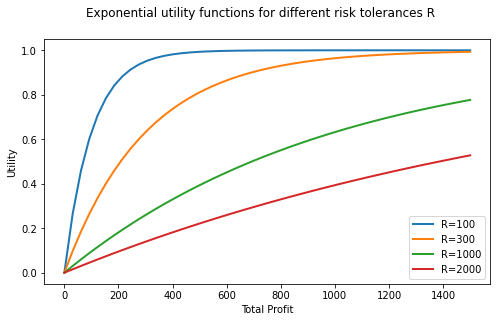

In [28]:

risk_tolerances = [100, 300, 1000, 2000]


xx = np.linspace(0, 1500)

#plt.plot(xx, xx, linewidth=2, label = 'Linear')
plt.figure(figsize=(8,4.5))
for risk_tolerance in risk_tolerances:
    yy = exponential_utility (xx, risk_tolerance)
    plt.plot(xx, yy, linewidth=2,label = f'R={risk_tolerance}')

plt.suptitle('Exponential utility functions for different risk tolerances R')
plt.legend()

plt.xlabel('Total Profit')
plt.ylabel('Utility')


#plt.savefig("utility_functions.pdf",bbox_inches="tight")
plt.show()



## Optimizing Expected Utility

If we use the utility function for decision-making, we maximize the expected utility, that is:

$$\max_{x \in X} E(u(f(x,D)))$$

In our example, this means that we choose the capacity that give us the outcome / profit distribution with the best expected profit.
- to achieve this, we define the following objective function that takes a capacity decision, an array of demand samples and a risk tolerance $R$, and returns a sample approximation of the expected utility:

In [29]:
def expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance):
    return np.mean(exponential_utility(total_profit(capacity,demands), risk_tolerance))

For use with scipy's `minimize`, we can write the negated objective function as follows:

In [30]:
def neg_expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance):
    return -expected_exponential_utility_fixed_risk_tolerance (capacity, demands, risk_tolerance)

## Results for different risk tolerances

Now, we can play with different risk tolerances:
- $R$ = 100

In [31]:
risk_tolerance = 100
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 100, the optimal capacity decision is 19.14


- $R$ = 500

In [32]:
risk_tolerance = 500
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 500, the optimal capacity decision is 63.87


- $R$ = 1000

In [33]:
risk_tolerance = 1000
result = minimize(neg_expected_exponential_utility_fixed_risk_tolerance, 100, args=(demands, risk_tolerance))
print(f'Given a risk tolerance of {risk_tolerance}, the optimal capacity decision is {result.x[0]:.2f}')

Given a risk tolerance of 1000, the optimal capacity decision is 74.09


# Deciding / Optimizing with Risk Measures

## The Value at Risk

**The q%-Value at Risk (VaR$_q$) of an outcome distribution G**
- is the outcome value separating the q% of the worst cases from the 1-q% of the best cases
- corresponds to the *q-percentile* or the *q/100 quantile* of $G$
- VaR is a risk measure often used in the financial industry and in risk reporting

**Given a set of |S| samples from $G$, VaR$_q$(G) can be obtained by**
- sorting the sample values $g_s$ in an increasing order and
- selecting the sample with first index that is greater than $q/100|S|$
- `numpy` offers functions for computing quantiles / percentiles:


In [34]:
capacity = 83
total_profit_samples = total_profit(capacity,demands)
alpha =  0.05
var_alpha = np.percentile(total_profit_samples, alpha*100)

print(f"For a capacity decision of {capacity} , the {alpha*100} percent value at risk is {var_alpha:0.2f}")


For a capacity decision of 83 , the 5.0 percent value at risk is -106.40


## Conditional Value at Risk

A **disadvantage** of VaR is that it does not consider **how bad** the outcomes below the VaR are


This is overcome by the **Conditional Value at Risk** (CVar). The **q%-CVaR (CVaR$_q$)** corresponds to
- the average / expected value of the distribution of values below VaR
- it is also called **Expected Shortfall**

**Given a set of |S| samples from $G$, CVaR$_q$(G) can be approximated by**
- taking the average of all samples $g_s$ falling below  VaR


In [35]:
total_profit_below_var = total_profit_samples[total_profit_samples <= var_alpha] 
cvar_alpha = total_profit_below_var.mean()
print(f"For a capacity decision of {capacity} , the {alpha*100} percent conditional value at risk is {cvar_alpha:0.2f}")

For a capacity decision of 83 , the 5.0 percent conditional value at risk is -543.01


## Value at Risk and Conditional Value at Risk

Let us visualize these Value at Risk and Condidtional Value at Risk along with the histogram of the distribution:


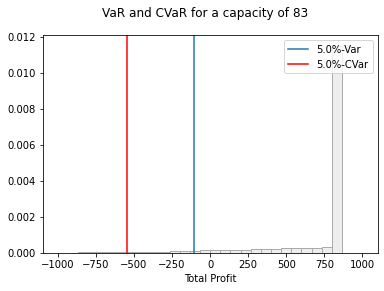

In [36]:

# plot value at risk according to different


count, bins, ignored = plt.hist(total_profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])

plt.suptitle(f'VaR and CVaR for a capacity of {capacity}')
plt.axvline(x=var_alpha, label = f'{alpha*100}%-Var')
plt.axvline(x=cvar_alpha, label = f'{alpha*100}%-CVar',color='r')
plt.xlabel('Total Profit')
plt.legend()
plt.show()

## Comparing CVaR and VaR for different capacities

Now, we compare VaR and CVaR for two capacity decisions that have almost the same expected total profit: 63 and 100

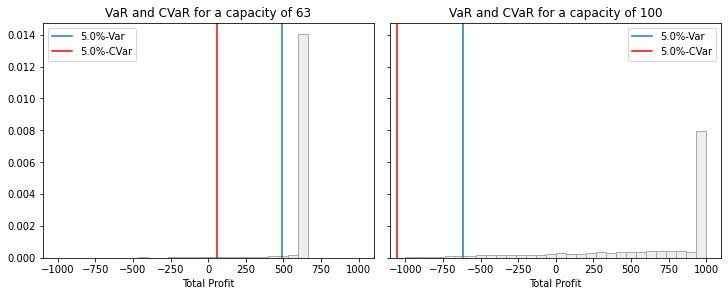

In [37]:
values_to_plot = [63, 100]


fig, axes = plt.subplots(1, len(values_to_plot), figsize=(5*len(values_to_plot), 4), constrained_layout=True, sharey=True)

for index in range(len(values_to_plot)):
    
    capacity =values_to_plot[index]
    total_profit_samples = total_profit(capacity,demands)

    var_alpha = np.percentile(total_profit_samples, alpha*100)

    total_pr_below_var = total_profit_samples[total_profit_samples <= var_alpha] 

    
    cvar_alpha = total_pr_below_var.mean()

    #print(cvar_q)
    
    count, bins, ignored = axes[index].hist(total_profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
    axes[index].set_title(f'VaR and CVaR for a capacity of {capacity}')
    axes[index].axvline(x=var_alpha, label = f'{alpha*100}%-Var')
    axes[index].axvline(x=cvar_alpha, label = f'{alpha*100}%-CVar',color='r')
    axes[index].set_xlabel('Total Profit')
    axes[index].legend()

#plt.savefig("var_and_cvar_comparison.pdf",bbox_inches="tight")
plt.show()



## Value at Risk and Conditional Value at Risk


**A note on notation**

In the literature, there are two ways of writing VaR and CVaR:
- using  $1-\alpha$ as subscript:  VaR$_{1-\alpha}$, e.g. VaR$_{0.95}$
- using only $\alpha$ as subscript: VaR$_\alpha$, e.g. VaR$_{0.05}$
- we will use the latter version

## Mean-Risk Objective Functions to Account for Risk Aversion

For decision making and optimization under uncertainty, we can use risk measures in so-called **mean-risk** objectives:

- similar to the shortfall penalty, we augment the objective by adding the risk measure (call it $h(x,D)$ here) with a weight $\lambda$
- the mean-risk objective to be maximized then becomes:

$$f^{mean-risk}(x,D) = E(f(x,D)) + \lambda h(x,D)$$

Here, we consider the tow cases VaR and CVaR:

$$f^{mean-VaR}(x,D) = E(f(x,D))+ \lambda \mathrm{VaR}(x,D)$$

$$f^{mean-CVaR}(x,D) = E(f(x,D))+ \lambda \mathrm{CVaR}(x,D)$$

##  Optimizing a Mean-Risk Objective with CVaR

Example implementation using `scipy.optimize`

In [39]:
def compute_cvar(sample_approximation, alpha):
    
    var_alpha = np.percentile(sample_approximation, alpha*100)

    total_pr_below_var = sample_approximation[sample_approximation <= var_alpha] 

    return total_pr_below_var.mean()


def mean_risk_objective_cvar(sample_approximation,lambd,alpha):
    return np.mean(sample_approximation) + lambd*compute_cvar(sample_approximation,alpha)

lambd = 2
alpha = 0.05 

def neg_mean_risk_capacity(capacity):
    return -1*mean_risk_objective_cvar(total_profit(capacity,demand_sample),lambd,alpha)

result = minimize(neg_mean_risk_capacity, 100)

print(f'Given a weight (lambda) of {lambd} and alpha= {alpha}, the optimal capacity decision is {result.x[0]:.2f}')

Given a weight (lambda) of 2 and alpha= 0.05, the optimal capacity decision is 53.71


# Mean-Risk Optimization with CVaR in Optimization under Uncertainty


##  VaR and CVaR in Optimization under Uncertainty


**Ex-post-computation of VaR and CVaR**
- we can use the distribution of outcomes, in case of sampling simply
  $\mathbf{g} = [g_s]_{s \in S}$
- and compute VaR and CVaR:

In [ ]:
VaR_sample = np.percentile(profit_samples, alpha*100,interpolation='lower')
profits_below_var = profit_samples[profit_samples <= VaR_sample] 
CVaR_sample = profits_below_var.mean()

print(f'VaR from profit samples: {VaR_sample:.02f}')
print(f'CVaR from profit samples: {CVaR_sample:.02f}')

## Mean-Risk-Optimization with VaR and CVaR in Stochastic Programming
- surprisingly, optimizing VaR is (much) harder than optimizing CVaR
- in this part, we will see a model for optimizing CVaR
- we may discuss the techniques for optimizing VaR next week

## Mean-Risk Optimization with CVaR: Optimization Model

**New Parameters:**
- $\alpha$: probability parameter for VaR and CVaR
- $\lambda$: weight for CVaR

**New Variables:**
- $v_s$: shortfall below VaR
- $VaR$: Value at Risk
- $CVaR$: Conditional Value at Risk


 \begin{align*}
        \max \;				&\sum_{s \in S}  p_s g_s + \lambda CVaR\\
        \text{s.t.} \qquad   g_s	&=  -30x +  40z_s\qquad		&\forall s \in S \\  
                         z_s		&\leq d_s \qquad		&\forall s \in S \\
         z_s				&\leq x \qquad			&\forall s \in S \\   
	 v_s				&\geq VaR - g_s			&\forall s \in S \\  
         CVaR				&= VaR - \frac{1}{\alpha}\sum_{s \in S} p_s v_s \qquad			 \\                  
                         x		&\geq 0 \\
			 v_s		&\geq 0, z_s \geq 0 \qquad	&\forall s \in S			 
\end{align*}


## Mean-Risk Optimization with CVaR: Python Implemementation

In [ ]:
# parameters for the mean-risk model
alpha = 0.05
lambd = 0.2

# Create a new model
m = mip.Model("Capacity_Planning_Stochastic_Mean_Risk")

#decision variables
capacity =  m.add_var(name="capacity", lb=0)
production = [m.add_var(name=f"production{s}",lb=0 ) for s in scenarios]

## this is the profit variable (scenario-dependent)
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

shortfall = [m.add_var(name=f"shortfall{s}",  lb=0) for s in scenarios] # scenario-dependent!

VaR = m.add_var(name="VaR", lb=-np.inf)
CVaR = m.add_var(name="CVaR", lb=-np.inf)

# in the objective, we now add a variable for the shortfall
m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)  + lambd*CVaR ) 

for s in scenarios:   
    m += profit[s]  == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 
    
    # computing shortfall below VaR
    m += shortfall[s] >= VaR - profit[s]

# Relating CVar and VaR
m += CVaR == VaR - 1/alpha* sum((1/n_scenarios)*shortfall[s] for s in scenarios)

## Mean-Risk Optimization with CVaR: Results

In [ ]:
m.optimize()

print(f'Results for a alpha = {alpha} and lambda = {lambd}')
print(f'Capacity decision: {capacity.x:.02f}')
print(f'Objective function value: {m.objective_value:.02f}' )

profit_samples = np.array( [ profit[s].x for s in scenarios ])
print(f' Expected Profit: {np.mean(profit_samples):.02f}')
print(f'CVaR variable: {CVaR.x:.02f}')
print(f'VaR variable: {VaR.x:.02f}')

# Risk Aversion and Neglecting Dependencies

## Case Study: A Farmer's Problem (Deterministic)

- a farmer has 450 acres of farmland and now has to decide how many
  acres to plant with the three crops wheat, corn and beets
- he needs some amount of  each crop for feeding his cattle
- if he harvests less than needed, he can buy crops on the market
- surplus can be sold on the market


| parameter          | unit       | wheat | corn | beets |
|:-------------------|:-----------|-------|------|-------|
| crop yield         | t per acre |   2.5 |    3 |    12 |
| planting costs     | \$ per acre |   150 |  180 |   210 |
| needed for feeding | t          |   200 |  250 |   720 |
| buying price       | \$ per t    |   290 |  260 |    70 |
| selling price      | \$ per t    |   200 |  180 |    45 |

**How much area should the farmer devote to each crop to maximize his profit?**

## Extension: Uncertain Crop Yields $h_i$


**Crop yields are subject to uncertainty**
- we now assume that crop yields are uncertain
  - we assume that we have a **joint distribution** for yields accounting
    for causal structure
- planting decisions have to be taken before knowing crop yields
- buying and selling can happen after harvesting the crops
- we assume that buying and selling prices are **not** affected by uncertainty

<img width='90%' src='img/farmer_information_structure.png'>

## Exercise: Risk Aversion and Neglecting Dependencies?

- create a set of **inconsistent crop yield samples / scenarios** for that case study
  - hint: you may use the function ``np.random.permutation`` to "shuffle" the sample vectors for wheat, crop and corn (shuffle only "within" one type of crop, of course)
- use the "inconsistent" crop yield for optimization
  - using  expected profit as objective function
  - using mean-risk with CVaR as objective function
 
- compare those results to the results obtained with the consistent samples. What is the difference?

## Summary of the Results 
**In this case study,** neglecting dependencies
- does not affect the expected value (and the decisions in an EV-Optimization)
- but it leads to a massive underestimation of risk
- and thus to wrong decisions when using risk-averse objectives!


<img width='90%' src='img/farmer_results.png'>

# Part II: Chance-Constrained Programming

## Motivation

In our case studies discussed so far, we assumed that there are second-stage decisions:
- Capacity Planning: adapting production to demand
- Farmer's problem: buying and selling crops on the market

**What if we assume that we cannot react?**
- we will either have enforce a safe solution
- or tolerate a certain violation
- in many setting, we may see this as a **service level**
  - for example, on-time guarantees in logistics

## Chance-Constrained Programming: Overview


In this part, we learn how to create optimization models
under uncertainty providing probabilistic guarantees

**In particular, we will discuss**
- how to model cases in which a single constraints are affected by
  uncertainty using **chance constraints**
- how to model **joint chance constraints** providing a feasibility
  guarantee for problems in which multiple constraints are affected by
  uncertainty
- how to **improve joint chance constraint formulations** to make then solvable faster

 


# Belt Manufacturing Case Study as an Illustration

## Case Study: Manufacturing Belts

- A small company manufactures two types of belts: A  and B. The contribution margin  \\$2 for an A-belt and \\$1.5 for a B-belt.
- It plans the production for a week, and it can sell its full production to small chain of shops.
- Producing a belt of type A takes twice as long as producing one of
  type B, and the total time available in that week would allow
  producing 1000 belts of type B if only B-belts were produced.
- Both types of belts require the same amount of leather, and there is enough leather to produce 800 belts.
- The total number that can be produced per type is limited by the number of available bucks: The company has 400 bucks for type A and 700 bucks for type B.

Create an LP model that determines the number of belts from each type to produce if the shop aims at maximizing the total contribution margin!

## Case Study: Manufacturing Belts - Deterministic LP

**Set**
- $I = \{A,B\}$ belt types

**Decision Variables**
- $x_i$: number of belts to produce from type $i$

\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq 1000 \\
		    	   x_A + x_B &\leq 800 \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 
\end{align*}

The optimal production plan is $x_A=200, x_B=600$ yielding a total profit of $1300.


## Case Study: Manufacturing Belts - Deterministic LP in Python

In [ ]:
belt_types = np.arange(2)
profit_contribution = [2, 1.5]
time_consumption = [2, 1]

time_available = 1000
leather_available = 800
bucks_available = [400, 700]


# Create a new model
m = mip.Model("Belt_Production_Deterministic")


#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]
m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available 
m += sum (production[b] for b in belt_types) <= leather_available 

m.optimize()

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )



## Uncertain Machine Time without Recourse


- let us now assume that due to random machine failures, the **available
  time is subject to uncertainty**
- however, due to contractual obligation, the company has to commit to
  a production plan **before** the machine time is known
  - the production decisions are thus **here and now decisions**
- in this part, we assume that there is **no recourse decision**
- given that the random variable describing the available time is
  $B_T$, the uncertain constraint is:


$$2x_A + x_B \leq B_T$$

$\rightarrow$ if our first-stage decisions are bad, the model becomes
**infeasible for certain scenarios**

## Uncertain Machine Time: The Data


We assume that the machine time follows a normal distribution:

In [ ]:
# avaible_time
time_available_dist = stats.norm(1000,150)

n_samples = 1000

# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
time_available_samples = np.maximum(time_available_dist.rvs(n_samples, random_state=42),0)

count, bins, ignored = plt.hist(time_available_samples , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
plt.xlabel('time available')
plt.show()

## Uncertain Machine Time: How likely is it that our Solution is Infeasible?

The following function can be used to estimate the feasibility of a production plan:

In [ ]:
def probability_production_plan_is_feasible (production_decisions, time_available_samples):
    return np.mean([2 * production_decisions[0] + production_decisions[1] <= time_available for time_available in time_available_samples])

Let's apply it to our optimal deterministic decision:

In [ ]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_samples)

print (f'The production plan is feasible with probability {probability_of_feasibility:.02f}')

# Ensuring Feasibility

## Enforcing Feasibility for each Scenario?

What if we want to establish feasibility for each scenario?
- the time constraint becomes: $\quad 2x_A + x_B \leq b_{T,s} \qquad \forall s \in S$
- which is equivalent to the single constraint:
 $\quad 2x_A + x_B \leq \min\limits_{s \in S} b_{T,s}$
- note that $\min\limits_{s \in S} b_{T,s}$ can be  computed **before** solving the problem

Note that this approach, sometimes called **fat solution**, 
- is extremely conservative / pessimistic 
- may lead  completely infeasible model instances in more complex cases
- depends a lot on the samples that are drawn:
  - different samples can result in very different solutions
  - more samples tend to result in more pessimistic decisions

### Ensuring Feasibility for each Scenario

If we want the model to be feasible for each scenario, we just use the minimum of the available time over all sample values.

In [ ]:
# Create a new model
m = mip.Model("Belt_Production_Pessimistic")

min_time_avaible = np.min(time_available_samples)

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= min_time_avaible 
m += sum (production[b] for b in belt_types) <= leather_available 

m.optimize()

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

### Ensuring Feasibility for each Scenario: Evaluating the Solution

We may evaluate the solution, and of course it should be feasible

In [ ]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_samples)

print (f'The production plan is feasible with probability {probability_of_feasibility:.02f}')

We may also evaluate it using a new sample, resulting in a so-called *out-of-sample* evaluation

In [ ]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_dist.rvs(100000, random_state=42))

print (f'The production plan is feasible with probability {probability_of_feasibility}')

**Exercise:** 

Experiment with different samples of the same size and samples of different sizes and see the effects on the decisions and on the profit!

# Chance Constraints

## Chance Constraints: Key Idea

**Key Idea:**
- 100% feasibility is often very expensive
- instead ensure that the probability of feasibility is $\geq \alpha$

Formally expressed, given a constraint $C$, a **chance constraint** can be written as:

$$P(C\: \mathrm{holds}) \geq \alpha$$

In our example, given $B_T$ as the random variable for available time:

$$P(2x_A + x_B \leq B_T) \geq \alpha$$

- if only a single constraint is affected by uncertainty, a single
  chance constraint ensures that the solution is feasible with a probability $\geq \alpha$
- if more constraints are uncertain, we have **joint chance constraints** (considered in video 2)

## How to Model a Chance Constraint?

Given that $B_T$ is a random variable and $\alpha$ is
the desired probability of feasibility, how can we model the chance constraint:

$$P(2x_A + x_B \leq B_T) \geq \alpha$$

**Key Idea:**
    
Assume that we have a set $S$ of scenarios. Then we can approximate
the chance constraint by ensuring that the constraint is violated in
at most $(1-\alpha)|S|$ scenarios
- we can achieve this by sorting the scenarios from the most to the least restricting  and
- taking the value $b^{\alpha}_{T}$ below which $(1-\alpha)|S|$
  values fall and using it in the right hand side of the constraint:


$$2x_A + x_B \leq b^{1-\alpha}_{T}$$

- this way, there are at most $\alpha |S|$ scenarios violating the  constraint 
- for example, in case of $\alpha=0.95$ and $|S|$ = 1000,
  $b^{1-\alpha}_{T,s}$ is the 51th-smallest value from all scenarios




## Chance Constraints Using Quantiles

- observe that the value $b^{1-\alpha}_{T}$ corresponds to the
  $(1-\alpha)$ quantile of the sample distribution
- thus, if we have a random distribution for which we can compute the
  $(1-\alpha)$ quantile directly (without sampling), we can use it without resorting to sampling
- for our example, the full model looks as follows:


$\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq b^{1-\alpha}_{T} \\
		    	   x_A + x_B &\leq 800 \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 
\end{align*}$

- observe that the model does *not* involve scenarios but has
  the same size as the deterministic model - we only replace $b_T$ with $b^{1-\alpha}_T$.


### Individual Chance Constraints

Given that we have a single chance constraint, we can ensure feasibility with probability $\alpha$ by replacing the uncertain right hand side parameter with the $1-\alpha$-quantile of the distribution.



In [ ]:
# Create a new model
m = mip.Model("Belt_Production_Single_Chance_Constraint")


alpha = 0.95

#in scipy stats, we get the quantile using the function ppf (inverse cumulative distribution function)
# we may also get the quantile from the set of samples!
time_available_quantile = time_available_dist.ppf(1-alpha)

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available_quantile
m += sum (production[b] for b in belt_types) <= leather_available 

### Individual Chance Constraints: Solving and Evaluating the Model

In [ ]:
m.optimize()

production_decisions = [production[b].x for b in belt_types]

for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Let us use Monte-Carlo simulation to verify:

In [ ]:
    
      
# let's evaluate feasibility using sampling!
probability_of_feasibility_from_sampling =  probability_production_plan_is_feasible (production_decisions, time_available_dist.rvs(5000, random_state=42))

print (f'Using Monte Carlo, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')

# Joint Chance Contraints

## But: What Happens in Case of  Multiple Uncertain Constraints?

**Let us now assume that both resource constraints are uncertain:**
- no only time, but also leather capacity is affected by uncertainty, e.g. due
  to quality issues, represented by the random variable $B_L$
- as in the time case, there is no second-stage / recourse decision is available

**Question:** How can we ensure that our plan is feasible with a probability of $\alpha$?

- more formally, how can we ensure the so-called *joint chance constraint*

$$ P \left( \begin{array}{r}  2 x_A + x_B \leq B_T \\  x_A + x_B \leq B_L \end{array} \right) \geq \alpha$$ 


## Uncertain Leather Availability: Probability Distribution

We assume that leather availability is normally distributed:

In [ ]:
# available leather
leather_available_dist = stats.norm(800,100)


# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
leather_available_samples = np.maximum(leather_available_dist.rvs(n_samples, random_state=42),0)

count, bins, ignored = plt.hist(leather_available_samples , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
plt.xlabel('leather available')
plt.show()

## What about using two single chance constraints to model the joint chance constraint?


We may enforce that

$P(2x_A + x_B \leq B_{T}) \geq \alpha$ **and**  $P(x_A + x_B \leq B_{L}) \geq \alpha$ 


by the following constraints:

 \begin{align*}
  2x_A + x_B &\leq b^{1-\alpha}_{T} \\
   x_A + x_B &\leq b^{1-\alpha}_{L} 
\end{align*}



**Does this imply that the problem is feasible with  probability  $\alpha$?**
- Let's check in Python

## Quantile-Based Model for Two Chance Constraints in Python

In [ ]:
# Create a new model
m = mip.Model("Belt_Production_Single_Chance_Constraint")
m.verbose=1
belt_types = np.arange(2)
profit_contribution = [2, 1.5]
time_consumption = [2, 1]
bucks_available = [400, 700]

alpha = 0.95

#in scipy stats, we get the quantile using the function ppf (inverse cumulative distribution function)
# we may also get the quantile from the set of samples!
time_available_quantile = time_available_dist.ppf(1-alpha)
leather_available_quantile = leather_available_dist.ppf(1-alpha)


#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available_quantile
m += sum (production[b] for b in belt_types) <= leather_available_quantile

m.optimize()
production_decisions = [production[b].x for b in belt_types]

for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )


## Quantile-Based Model for Two Chance Constraints: Evaluation in Python

- in our model, we built the two constraints with $\alpha=0.95$
- how high is the probability that the solution is feasible with respect to both constraints?


In [ ]:


print(f'We want to ensure feasibility with probability {alpha}')


def probability_production_plan_is_feasible_time_and_leather  (production_decisions, time_available_samples, leather_available_samples):
    n_samples = time_available_samples.size
    feasible_samples = np.array([2 * production_decisions[0] + production_decisions[1] <= time_available_samples[s] 
                                 and production_decisions[0] + production_decisions[1] <= leather_available_samples[s] for s in range(n_samples)])
    return np.mean(feasible_samples)

n_samples_for_evaluation = 5000
samples_time = time_available_dist.rvs(n_samples_for_evaluation)
samples_leather = leather_available_dist.rvs(n_samples_for_evaluation)

probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, samples_time, samples_leather )


print (f'Based on a Monte-Carlo approximation the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')


## Using Multiple Individual Chance Constraints?

As we learned in our example, in general, given a set of $n$ constraints affected by uncertainty and
a desired feasibility probability $\alpha$, the *joint chance
constraint* 

$$P( C_j \: \mathrm{holds} \quad \forall j=1\ldots n) \geq \alpha$$ 

is **not** enforced by using a set of single chance constraints of the form

$$P( C_j \: \mathrm{ holds} ) \geq \alpha \quad \forall j=1\ldots n$$


**Question**: How can we enforce a such joint chance constraint?
- note that in case of multiple uncertain constraints, the scenarios
  can no longer be ordered according to strictness of constraints
- for example, given two scenarios in the belt production case study,
  one may have a smaller $b_T$ and the other a smaller $b_L$


# Using Binary Variables for Modelling Joint Chance Constraints

## Modeling Chance Constraints using Scenarios and Binary Variables

**Key Idea: Let the solver decide which scenarios should hold**

- introduce a binary variable $y_s$ for each scenario $s \in S$:
  - $y_s = 0$ means that in scenario $s$, all uncertain constraints hold
  - $y_s = 1$ means that in scenario $s$, at least one constraint may be violated

- introduce a constraint that ensures that the total probability of
  all scenarios for which $y_s = 1$ is $\leq 1-\alpha$:
  $$\sum_{s \in S} p_s y_s \leq 1-\alpha$$

- introduce a "scenario realization" for each uncertain constraint
  and each scenario $s$ and link that constraint to $y_s$ to switch it on or off

 \begin{align*}
2x_A + x_B &\leq b_{T,s} + M_T y_s &\forall s \in S\\
 x_A + x_B &\leq b_{L,s} + M_L y_s &\forall s \in S
\end{align*}



## The Model with Joint Chance Constraints

**Sets**
- $S$: scenarios
   
**Decision Variables:**
- $x_i$: number of belts to produce from type $i$
- $y_s$: binary indicator variable for infeasibility in scenario $s$


**Parameters:**
- $p_s$: probability of scenarios $s$
- $b_{r,s}$: availability from resource $r$ (time, leather) in scenario $s$
- $M_r$: big-M value for resource $r$ used to switch off constraint



\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq b_{T,s} + M_T y_s &\forall s \in S\\
		    	   x_A + x_B &\leq b_{L,s} + M_L y_s &\forall s \in S\\
			   \sum_{s \in S} p_s y_s &\leq 1-\alpha \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 \\
			   y_s &\in \{0,1\} &\forall s \in S
\end{align*}




## The Model with Joint Chance Constraints in Python

In [ ]:
alpha = 0.95
n_scenarios = 500
scenarios = np.arange(n_scenarios)
time_available = time_available_dist.rvs(n_scenarios, random_state=5)
leather_available = leather_available_dist.rvs(n_scenarios,  random_state=7)

In [ ]:
m = mip.Model("Belt_Production_Joint_Chance_Constraints")

#probability of each scenario
prob = np.full((n_scenarios), 1.0/n_scenarios)


#bigM is used for switching off constraints by adding it to the resource capacity in a scenario
#if it is chosen as difference between the max and min capacity, it is definitely large enough to switch off the constraint
bigM = [max(time_available)-min(time_available),max(leather_available)-min(leather_available)]

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

#y-variable
is_scenario_violated = [m.add_var(name=f"is_feasible{s}", var_type=mip.BINARY ) for s in scenarios]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# one set of constraints per scenario
for s in scenarios:
    m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available[s] + bigM[0]*(is_scenario_violated[s])
    m += sum (production[b] for b in belt_types) <= leather_available[s] + bigM[1]*(is_scenario_violated[s])

# ensure that the right number of scenarios hold
m += sum(prob[s]*is_scenario_violated[s] for s in scenarios) <= 1-alpha - 2.0 / n_scenarios

## The Model with Joint Chance Constraints In Python


In [ ]:
from time import time

start_time = time()
m.optimize()
print(f"Solution time: {time()-start_time} seconds")

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Let us now evaluate the probability of having an infeasible model.

- first, using the same 500 samples we used in the model

In [ ]:
print(f'We want to ensure feasibility with probability {alpha}')
probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, time_available, leather_available)

print (f'Using Monte Carlo for the samples used in the optimization, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')

- and then, using 5000 new sample (out-of-sample evaluation)

In [ ]:
n_samples_for_evaluation = 10000
probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, time_available_dist.rvs(n_samples_for_evaluation), leather_available_dist.rvs(n_samples_for_evaluation))

print (f'Using Monte Carlo with different samples, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.03f}')

## The Model is Hard to Solve

**What makes the model hard to solve?**
- many binary variables along with BigM-constraints
- a lot of symmetry (many equivalent or almost equivalent solutions)

**Can we do something about it?**
- **yes:** we can improve the model by adding information that we know about the problem


**Idea 1**: We can use the fact that some scenarios are more restricted than others 


**Idea 2**: Based on that, we can tell in advance that some scenarios
won't belong to the $1-\alpha$ for which constraints are violated


## Idea 1: Some Scenarios are Restricted More than others: Enforcing Order Relations


Consider three scenarios:

| s | $p_s$ | $b_{T,s}$ | $b_{L,s}$ |
|-----|-----|-----------|-----------|
| 1 | 1/3 |       900 |      1100 |
| 2 | 1/3 |      1000 |       800 |
| 3 | 1/3 |      1000 |      1200 |

- we cannot completely order these scenarios (no *total ordering*)
- but we see that 3 is less strict than 1 *and* less strict than 2
- and thus if a solution is infeasible for scenario 3, it is implied
  that it is also infeasible in scenarios 1 and 2
- we can add that information to the model  adding constraints:

$$y_3 \leq y_1$$
$$y_3 \leq y_2$$

- adding these constraints help finding a solution faster since we add
  information that the solver does not infer by itself
- observe: there may be **many** of these constraints


## Idea 2: Eliminating / Fixing y-Variables
Given idea 1, we can infer that for a given $\alpha$, certain scenarios are "safe"

Consider three scenarios:

| s | $p_s$ | $b_{T,s}$ | $b_{L,s}$ |
|---|-----|-----------|-----------|
| 1 | 1/3 |       900 |      1100 |
| 2 | 1/3 |      1000 |       800 |
| 3 | 1/3 |      1000 |      1200 |


**Example:** Consider the scenarios from the table and let $\alpha=2/3$
- we know that at most one scenario is allowed to be violated
- since scenario 3 is less strict than the other two, we know that
  $y_3$ will be 0 in the optimal solution
- we can thus either fix the variable to 0  or eliminate it right away


## Evaluating Idea 2:  Fix Y-Variables for Scenarios that Won't be Violated

*Observe: Here, we assume that all scenarios are equally likely. However, the apporach can be generalized to account for general scenario probabilities $p_s$*

**Python Implementation:**

We first compute the number of stricter scenarios for each scenario:

In [ ]:
number_of_stricter_scenarios = np.zeros(n_scenarios)

for s1 in scenarios:
    for s2 in range(s1+1,n_scenarios):
        if leather_available[s1] <= leather_available[s2] and time_available[s1] <= time_available[s2]:
            number_of_stricter_scenarios[s2] += 1            
        elif leather_available[s1] >= leather_available[s2] and time_available[s1] >= time_available[s2]:
            number_of_stricter_scenarios[s1] += 1
            

For a given set of scenarios $S$ and for a given $\alpha$:
- if at most  $(1-\alpha)|S|$ scenarios are violated, our desired feasibility probability is reached
- thus, if, for a given scenario $s$, more than $(1-\alpha)|S|$ scenarios are stricter than $s$, then these will be violated "before" $s$ and thus do not need to be considered
- in the model on the next slide, we force the y variables of these scenarios to be zero


## Evaluating Idea 2: The Model

In [ ]:
m = mip.Model("Belt_Production_Joint_Chance_Constraints_only_idea_2")

#probability of each scenario
prob = np.full((n_scenarios), 1.0/n_scenarios)

alpha = 0.95

production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

#y-variable
is_scenario_violated = [m.add_var(name=f"is_feasible{s}", var_type=mip.BINARY ) for s in scenarios]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# one set of constraints per scenario
for s in scenarios:
    m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available[s] + bigM[0]*(is_scenario_violated[s])
    m += sum (production[b] for b in belt_types) <= leather_available[s] + bigM[1]*(is_scenario_violated[s])

# ensure that the right number of scenarios hold
m += sum(prob[s]*is_scenario_violated[s] for s in scenarios) <= 1-alpha

# the new set of constraints
for s in scenarios:
    if number_of_stricter_scenarios[s] >= (1-alpha)*n_scenarios:
        m += is_scenario_violated[s] == 0


## Evaluating Idea 2: Solution time

Let us solve the model: How long does it take?

In [ ]:

start_time = time()

m.optimize()

print(f"Solution time: {time()-start_time}")
    
production_decisions = [production[b].x for b in belt_types]

print(f'We want to ensure feasibility with probability {alpha}')

for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

## Summary

In the two parts of this meeting, we dealt with approaches for avoiding undesired outcomes:

#### Part I:  Risk Orientation / Decision-Making as Shaping Distributions
- Decision Making under Uncertainty as Shaping Distributions
- Comparing Distributions: Stochastic Dominance
- Shaping Distributions by Incorporating Risk Attitude into Decision / Optimization Models

#### Part II: Feasibility Guarantees by Chance-Constrained Programming
- Feasibility Issues in Single-Stage Problems under Uncertainty
- Single Chance Constraints
- Joint Chance Constraints
- Improving Chance-Constrained Programming Formulations

